<a href="https://colab.research.google.com/github/bonareri/Bitcoin-Prediction-Analysis/blob/main/prophet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Install the Necessary Library

In [92]:
# Installing the reuired library
!pip install prophet

In [93]:
# Data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime

# For Facebook Prophet (time series forecasting)
from prophet import Prophet
from prophet.plot import plot_plotly

# Evaluiation
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_absolute_error, mean_squared_error

## 2: Load and Prepare the Dataset

In [94]:
# Load preprocessed data
df = pd.read_csv('/content/bitcoin_analysis_engineered.csv')

# Display the first few rows of the data
df.head()

,Date,Open,High,Low,Close,Volume,Market Cap,Coin,Year,Month,...,Quarter,Weekday,Daily_Return,Log_Return,EMA_7,EMA_30,RSI_14,MA_20,Upper_BB,Lower_BB
0,2014-10-06,320.389008,345.134003,302.559998,330.079010,79011800,6.542676e+09,Bitcoin,2014,10,...,4,0,0.029856,0.029419,349.294184,398.996478,30.138935,389.910399,461.027732,318.793066
1,2014-10-07,330.584015,339.247009,320.481995,336.187012,49199900,6.663746e+09,Bitcoin,2014,10,...,4,1,0.018505,0.018336,346.017391,394.944255,17.642549,383.853049,451.334641,316.371457
2,2014-10-08,336.115997,354.364014,327.187988,352.940002,54736300,6.995816e+09,Bitcoin,2014,10,...,4,2,0.049832,0.048630,347.748044,392.234303,27.775351,380.278049,446.265429,314.290669
3,2014-10-09,352.747986,382.726013,347.687012,365.026001,83641104,7.235380e+09,Bitcoin,2014,10,...,4,3,0.034244,0.033671,352.067533,390.478929,35.319233,378.789549,444.741094,312.838004
4,2014-10-10,364.687012,375.066986,352.963013,361.562012,43665700,7.166718e+09,Bitcoin,2014,10,...,4,4,-0.009490,-0.009535,354.441153,388.613321,36.159745,376.422450,441.211135,311.633765


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3779 entries, 0 to 3778
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          3779 non-null   object 
 1   Open          3779 non-null   float64
 2   High          3779 non-null   float64
 3   Low           3779 non-null   float64
 4   Close         3779 non-null   float64
 5   Volume        3779 non-null   int64  
 6   Market Cap    3779 non-null   float64
 7   Coin          3779 non-null   object 
 8   Year          3779 non-null   int64  
 9   Month         3779 non-null   int64  
 10  Day           3779 non-null   int64  
 11  Quarter       3779 non-null   int64  
 12  Weekday       3779 non-null   int64  
 13  Daily_Return  3779 non-null   float64
 14  Log_Return    3779 non-null   float64
 15  EMA_7         3779 non-null   float64
 16  EMA_30        3779 non-null   float64
 17  RSI_14        3779 non-null   float64
 18  MA_20         3779 non-null 

### Preprocess the Data

Prophet expects a dataframe with two columns:

- ds: The date column (datetime format).
- y: The target variable (values to forecast).

In [96]:
# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set Date as index
df.set_index('Date', inplace=True)

# Prepare dataframe for Prophet
df_prophet = df.reset_index()[['Date', 'Close']]
df_prophet.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

In [98]:
df_prophet

,ds,y
0,2014-10-06,330.079010
1,2014-10-07,336.187012
2,2014-10-08,352.940002
3,2014-10-09,365.026001
4,2014-10-10,361.562012
...,...,...
3774,2025-02-04,97871.820312
3775,2025-02-05,96615.445312
3776,2025-02-06,96593.296875
3777,2025-02-07,96529.085938


### Train-Test Split


In [99]:
split_date = '2023-12-31'  # Last day of 2023

df_train = df_prophet[df_prophet['ds'] <= split_date]
df_test = df_prophet[df_prophet['ds'] > split_date]

### Train Prophet Model

In [100]:
# Initialize the Prophet model
model = Prophet()

In [101]:
# Add relevant features as regressors
extra_features = ['Volume', 'EMA_7', 'EMA_30', 'RSI_14', 'MA_20', 'Upper_BB', 'Lower_BB']

for feature in extra_features:
    model.add_regressor(feature)

# Fit model with training data
model.fit(df_train.merge(df[extra_features], left_on='ds', right_index=True))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbneqf1tc/x87f6wal.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbneqf1tc/qq_732pw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7323', 'data', 'file=/tmp/tmpbneqf1tc/x87f6wal.json', 'init=/tmp/tmpbneqf1tc/qq_732pw.json', 'output', 'file=/tmp/tmpbneqf1tc/prophet_modeleph6jxzv/prophet_model-20250210072748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:27:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:27:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Make Future Predictions

In [102]:
future = model.make_future_dataframe(periods=len(df_test), freq='D')

# Merge extra features for test period
future = future.merge(df[extra_features], left_on='ds', right_index=True, how='left')

# Predict future values
forecast = model.predict(future)

In [104]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3774,2025-02-04,98422.971418,97511.645205,99347.707813
3775,2025-02-05,97473.925052,96564.548192,98349.970500
3776,2025-02-06,96636.418584,95745.533914,97506.124443
3777,2025-02-07,95929.587736,95011.246526,96827.840422
3778,2025-02-08,95403.648038,94479.851133,96269.652948


The forecast dataframe includes:

- ds: The date.
- yhat: The predicted value.
- yhat_lower and yhat_upper: The lower and upper bounds of the prediction interval.

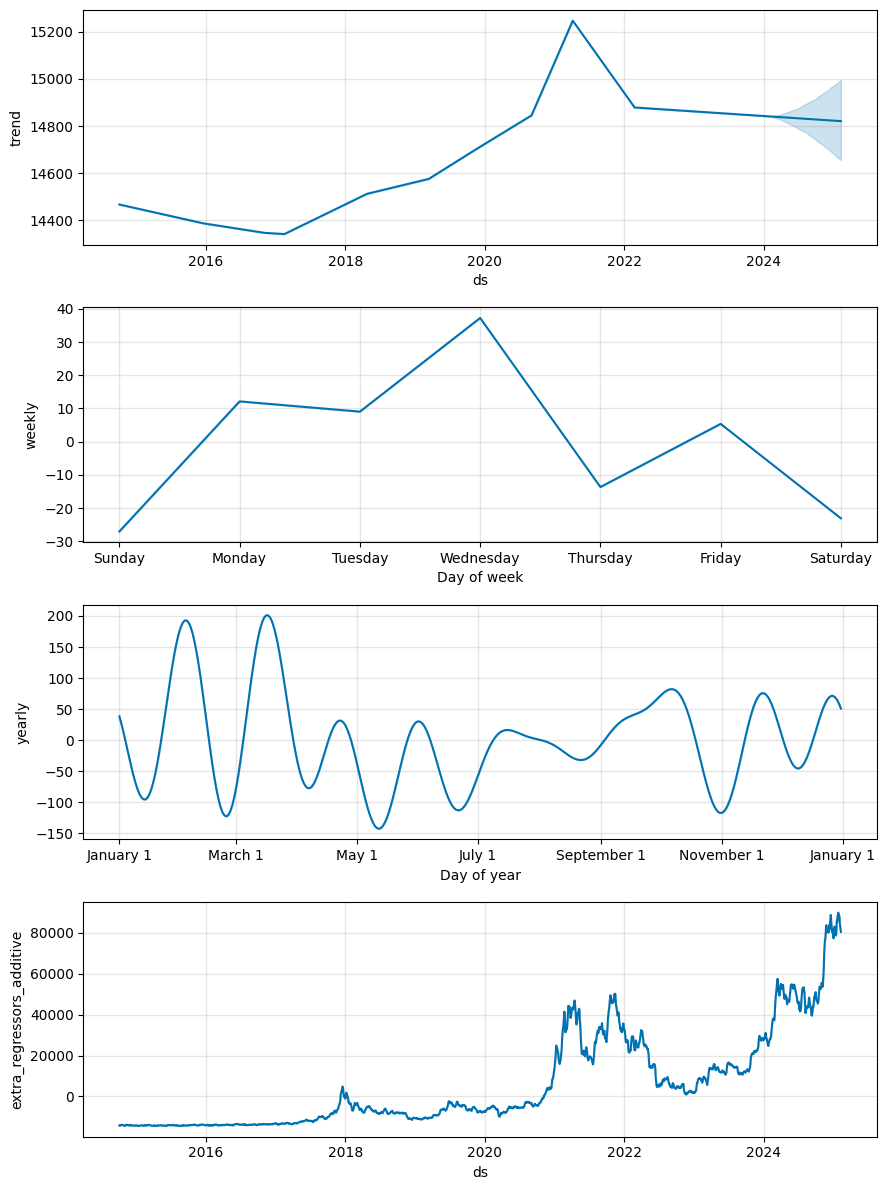

In [106]:
#seasonality
fig_2 = model.plot_components(forecast)
plt.show()

### Evaluate Model Performance

In [107]:
# Extract actual vs predicted values
df_test_forecast = forecast.set_index('ds').loc[df_test['ds']]['yhat']

# Compute metrics
mae = mean_absolute_error(df_test['y'], df_test_forecast)
mse = mean_squared_error(df_test['y'], df_test_forecast)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


MAE: 1271.3036901818457
MSE: 2968080.2376453495
RMSE: 1722.811724375403


### Visualize predictions

### Basic Prophet Forecast Plot


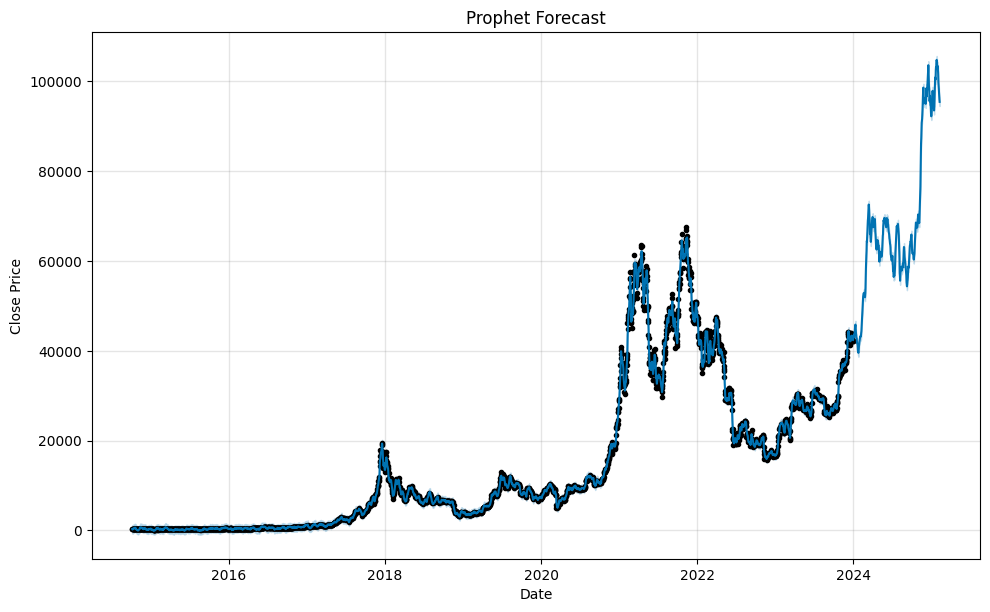

In [108]:
# Plot the forecast
model.plot(forecast)
plt.title("Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

### Compare Predictions vs Actual

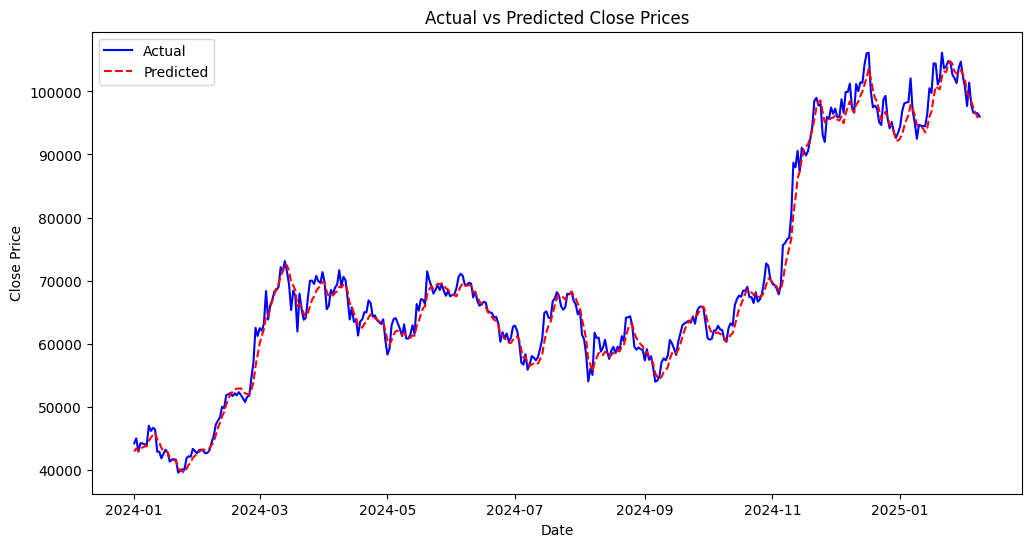

In [109]:
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(df_test['ds'], df_test['y'], label="Actual", color='blue')

# Plot predicted values
plt.plot(df_test['ds'], df_test_forecast, label="Predicted", color='red', linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Actual vs Predicted Close Prices")
plt.legend()
plt.show()

### Components of Prophet Model

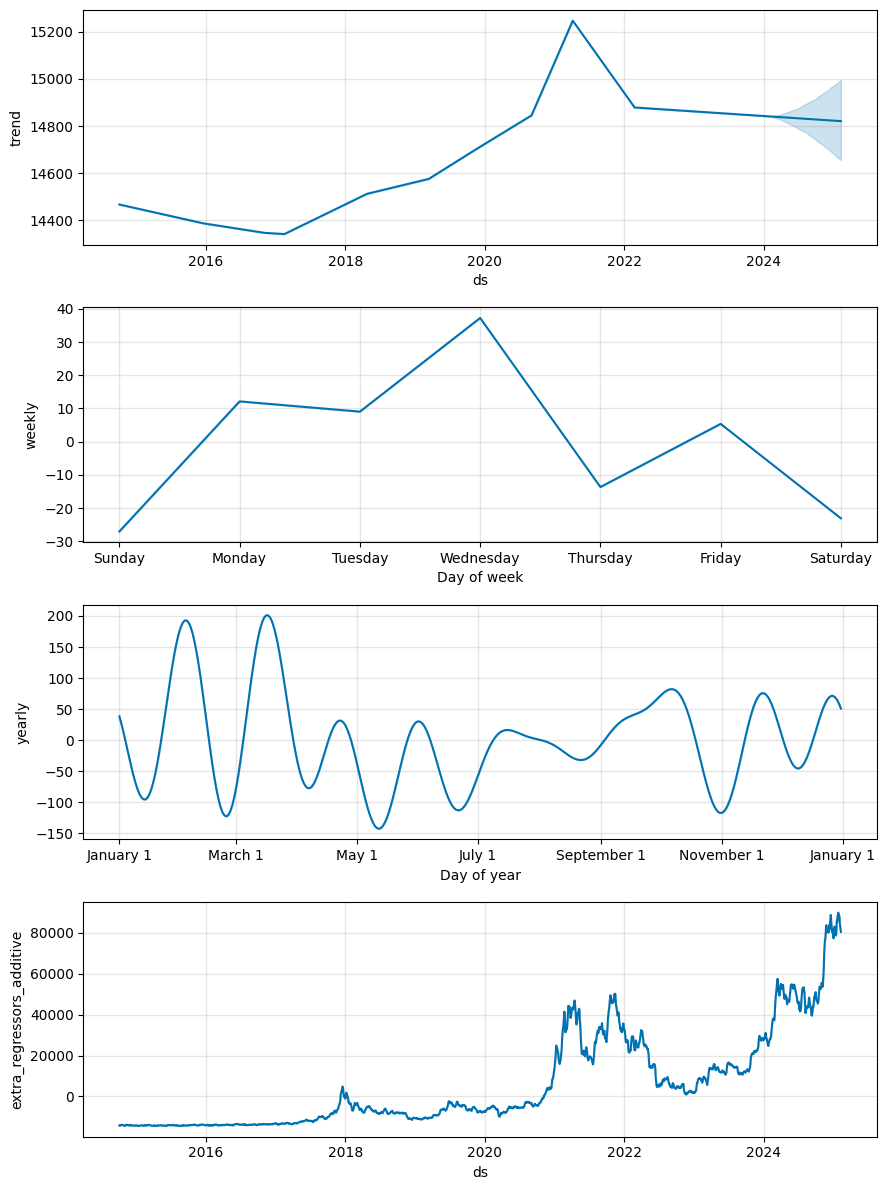

In [110]:
model.plot_components(forecast)
plt.show()

## 7. Diagnostics

In [111]:
df_cv = cross_validation(model, horizon = '365 days')

INFO:prophet:Making 11 forecasts with cutoffs between 2018-01-01 00:00:00 and 2022-12-31 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbneqf1tc/28_auk3f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbneqf1tc/qx3w2rwl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53411', 'data', 'file=/tmp/tmpbneqf1tc/28_auk3f.json', 'init=/tmp/tmpbneqf1tc/qx3w2rwl.json', 'output', 'file=/tmp/tmpbneqf1tc/prophet_modelq6av_4wj/prophet_model-20250210073930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:39:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:39:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbneqf1tc/f0v6bmtn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbneqf1tc/qam58129.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [116]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-01-02,13615.169815,13379.356569,13860.273608,14982.099609,2018-01-01
1,2018-01-03,14021.143991,13768.817183,14247.402133,15201.000000,2018-01-01
2,2018-01-04,14572.017650,14335.330421,14821.346038,15599.200195,2018-01-01
3,2018-01-05,15844.436521,15611.661629,16072.833492,17429.500000,2018-01-01
4,2018-01-06,16890.609692,16659.479097,17123.894160,17527.000000,2018-01-01


In [113]:
df_performance = performance_metrics(df_cv)

In [114]:
df_performance

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days 12:00:00,728594.704232,853.577591,555.227328,0.031072,0.021148,0.030579,0.625935
1,37 days 00:00:00,734261.371875,856.890525,559.763986,0.031174,0.021140,0.030677,0.621363
2,37 days 12:00:00,731394.314377,855.215946,558.813763,0.031085,0.021148,0.030579,0.623441
3,38 days 00:00:00,732915.179271,856.104654,560.395866,0.031155,0.021239,0.030651,0.619285
4,38 days 12:00:00,729418.243760,854.059860,559.359390,0.031160,0.021239,0.030641,0.615960
...,...,...,...,...,...,...,...,...
653,363 days 00:00:00,837596.010870,915.202716,660.567077,0.036792,0.029496,0.037262,0.504156
654,363 days 12:00:00,848261.290873,921.011016,667.962123,0.037230,0.029971,0.037673,0.496259
655,364 days 00:00:00,843517.760813,918.432230,667.993155,0.037275,0.030127,0.037713,0.494597
656,364 days 12:00:00,847545.658679,920.622430,670.670563,0.037349,0.030232,0.037752,0.491272


In [115]:
print(f"MAE: {df_performance['mae'].values[0]}")
print(f"MSE: {df_performance['mse'].values[0]}")
print(f"RMSE: {df_performance['rmse'].values[0]}")

MAE: 555.2273277213419
MSE: 728594.7042319695
RMSE: 853.5775912194331
